In [76]:
import pandas as pd

df = pd.read_csv('data_feeds_ss.csv',sep=';')

df.head()

,caption_text,media_id,link
0,Promo spesial edisi HUT ke-41 Suara Surabaya\n...,3381379831442085689,https://www.instagram.com/p/C7tEwqXxpc5/
1,HOT DEAL!\n\nPromo spesial edisi HUT SS ke-41\...,3380803740302499479,https://www.instagram.com/p/C7rBxbsCt6X/
2,"Bulan Juni, bulannya Suara Surabaya Media\n\nT...",3380744467995640686,https://www.instagram.com/p/C7q0S6DP0Nu/
3,Pemerintah menargetkan sebanyak 18 layanan pub...,3399444283877419505,https://www.instagram.com/p/C8tQJCuPunx/
4,"Jika kita memikirkan tentang expo kesehatan, s...",3399435427814099289,https://www.instagram.com/p/C8tOIK3vMlZ/


In [77]:
df.shape

(300, 3)

In [78]:
filter = df[df['caption_text'].str.contains('kejahatan|kriminalitas|curanmor|tawuran|pembakaran|pemerkosaan|perjudian|pembunuhan|begal|penipu|maling|pencurian|pencopetan|perampokan|penggelapan|pemalsuan|kekerasan|intimidasi|penipuan|penyelundupan|pembajakan|penganiayaan|pelecehan|terorisme|sabotase|pembantaian|mutilasi|penjambretan|peredaran narkoba|narkoba|narkotika|pembegalan|penculikan|eksploitasi|pemerasan|vandalism|premanisme|penyelundupan manusia|pengrusakan|pencabulan|penjarahan|penghinaan|pemalsuan identitas', case=False, na=False)]

In [79]:
import re

def clean_text(text):
    # Remove commas
    # text = text.replace(',', '')
    text = re.sub(r'\bRT\b', '', text)
    text = re.sub(r'#\S+', '', text)
    text = text.upper()
    text = re.sub(r'\(\d{1,2}/\d{1,2}/\d{4}\)', '', text)

    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    text = re.sub('@[^\s]+','AT_USER',text)

    text = re.sub(r'\[re\s+([^\]]+)\]', r'REPOST', text)
    # text = re.sub(r'\[re\s+([^\]]+)\]', lambda match: f'@{match.group(1)}', text)

    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',text)

    text = re.sub(r'\.{2,}', '.', text)

    text = re.sub(r'\bAT_USER\b', '', text)

    text = re.sub(r'\bURL\b', '', text)

    text = re.sub(r'\bREPOST\b', '', text)

    text = text.replace("'", "")

    text = text.strip()

    text = text.strip('\'"')

    text = re.sub(r'\s+', ' ', text)
    return text

# tweet = "RT Setelah memberikan dukungan melalui videotron, kini fandom 'Humanies' pendukung Capres 01, Anies Baswedan memberikan dukungan dengan mengirimkan food truck ke lokasi acara Desak Anies di Jakarta Selatan. #pemilupedia #newsupdate #update #news #videonews https://t.co/LT4ozwUIfT https://t.co/ct7zuIEcGO [RE kumparan]"
# processed_tweet = clean_text(tweet)
# print("Original Tweet:", tweet)
# print("Processed Tweet:", processed_tweet)

filter['caption_text'] = filter['caption_text'].apply(clean_text)
df['caption_text'] = df['caption_text'].apply(clean_text)

In [80]:
filter.shape

(42, 3)

In [81]:
indo_slang_word = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
slang_to_formal = dict(zip(indo_slang_word['slang'], indo_slang_word['formal']))

# Fungsi normalisasi teks
def normalize_text(text):
    words = text.split()  # Memecah teks menjadi kata-kata
    normalized_words = []
    for word in words:
        if word in slang_to_formal:
            normalized_words.append(slang_to_formal[word])
        else:
            normalized_words.append(word)
    normalized_text = ' '.join(normalized_words)  # Menggabungkan kata-kata kembali menjadi teks
    return normalized_text

filter['caption_text'] = filter['caption_text'].apply(normalize_text)
# df['caption_text'] = df['caption_text'].apply(normalize_text)

In [82]:
from indoNLP.preprocessing import pipeline, replace_word_elongation, replace_slang,remove_stopwords

# Define the normalization pipeline
pipe = pipeline([replace_word_elongation,replace_slang,remove_stopwords])

# Define the normalize_text function
def indonlp(text):
    return pipe(text)

filter['caption_text'] = filter['caption_text'].apply(indonlp)


In [83]:
from indoNLP.preprocessing import pipeline, remove_stopwords

# Define the normalization pipeline
pipe = pipeline([remove_stopwords])

# Define the normalize_text function
def indonlp(text):
    return pipe(text)

df['caption_text'] = df['caption_text'].apply(indonlp)

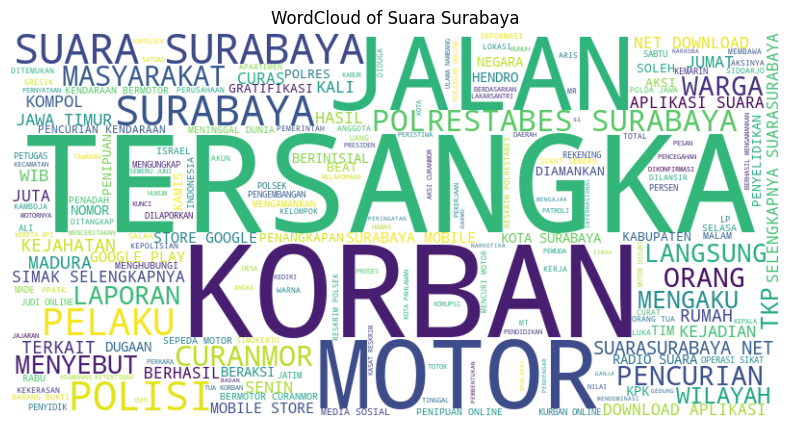

In [84]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan semua teks dari kolom 'caption_text'
text = ' '.join(filter['caption_text'].astype(str).tolist())

# Membuat wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Menampilkan wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Suara Surabaya')
plt.show()


In [85]:
import openai
# from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

In [86]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
keybert_model = KeyBERTInspired()


In [87]:
mmr_model = MaximalMarginalRelevance(diversity=0.3)

In [88]:
client = openai.OpenAI()
prompt = """
I have a topic that contains news from SuaraSurabaya media, which is a Surabaya city news platform: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, create a short but very descriptive topic label with 3 to 5 words. Make sure the label is in the following format:
topic: <topic label>
"""
openai_model = OpenAI(client, model="gpt-4o", exponential_backoff=True, chat=True, prompt=prompt)

In [89]:
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model,
    # "POS": pos_model
}

In [90]:
# from openai import OpenAI
# client = OpenAI()

# def get_embedding(text, model="text-embedding-ada-002"):
#    text = text.replace("\n", " ")
#    return client.embeddings.create(input = [text], model=model).data[0].embedding

# embeddings = filter.caption_text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))

In [91]:
import openai
from bertopic.backend import OpenAIBackend

client = openai.OpenAI()
embedding_model = OpenAIBackend(client, "text-embedding-ada-002")


In [92]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)


In [93]:
# Train model
topics, probs = topic_model.fit_transform(df.caption_text)


2024-06-28 12:36:53,041 - BERTopic - Embedding - Transforming documents to embeddings.
2024-06-28 12:36:56,762 - BERTopic - Embedding - Completed ✓
2024-06-28 12:36:56,763 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-28 12:36:59,086 - BERTopic - Dimensionality - Completed ✓
2024-06-28 12:36:59,087 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-28 12:36:59,097 - BERTopic - Cluster - Completed ✓
2024-06-28 12:36:59,100 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 7/7 [00:06<00:00,  1.15it/s]
2024-06-28 12:37:17,129 - BERTopic - Representation - Completed ✓


In [94]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs
0,-1,46,-1_surabaya_yamaha_00_smp,"[surabaya, yamaha, 00, smp, peserta, 2024, jag...","[surabaya, peserta, suarasurabaya, siswa, work...",[Surabaya Student Bootcamp 2024],"[surabaya, yamaha, 00, smp, peserta, 2024, jag...","[MINI BOOTCAMP ""JAGO TAMPIL"" PROGRAM INTENSIF..."
1,0,84,0_surabaya_korban_kota_tersangka,"[surabaya, korban, kota, tersangka, motor, jal...","[tersangka, kepolisian, polda, kapolsek, polre...",[Surabaya Vehicle Theft Arrests],"[surabaya, korban, kota, tersangka, motor, jal...",[POLSEK SUKOLILO BERHASIL MENGAMANKAN MALING M...
2,1,63,1_online_judi_kpk_satgas,"[online, judi, kpk, satgas, kementerian, indon...","[kemenkominfo, jenderal, judi, jakarta, ketua,...",[Satgas Pemberantasan Judi Online],"[online, judi, kpk, satgas, kementerian, indon...",[JOKO WIDODO (JOKOWI) PRESIDEN MENERBITKAN SUR...
3,2,34,2_haji_jemaah_ibadah_orang,"[haji, jemaah, ibadah, orang, tawaf, saudi, in...","[jamaah, jemaah, masjidil, jumrah, umrah, haji...",[Haji Pilgrims Activities Updates],"[haji, jemaah, ibadah, orang, tawaf, saudi, in...",[KLOTER KEPULANGAN JEMAAH HAJI DEBARKASI SURA...
4,3,30,3_suara_surabaya_darah_41,"[suara, surabaya, darah, 41, kpj, media, 22, s...","[surabaya, suara, sukomanunggal, sedunia, indo...",[Suara Surabaya Blood Donation],"[suara, surabaya, darah, 41, kpj, media, 22, s...",[SUARA SURABAYA (SS) MEDIA MENGGELAR KHITAN MA...
5,4,24,4_jazz_2024_run_traffic,"[jazz, 2024, run, traffic, festival, city, com...","[jazztraffic, surabaya, festival, jalan, jazz,...",[Jazz Traffic Festival 2024],"[jazz, 2024, run, traffic, festival, city, com...",[LAGU MELANKOLIS LIRIK PUITIS ROMANTIS KAHI...
6,5,19,5_hendy_indonesia_persebaya_piala,"[hendy, indonesia, persebaya, piala, surabaya,...","[pemimpin, indonesia, surabaya, hendy, wahyudi...",[Hendy Setiono & Surabaya News],"[hendy, indonesia, persebaya, piala, surabaya,...","[HENDY SETIONO , BONEK MEMALUKAN MEMB..."


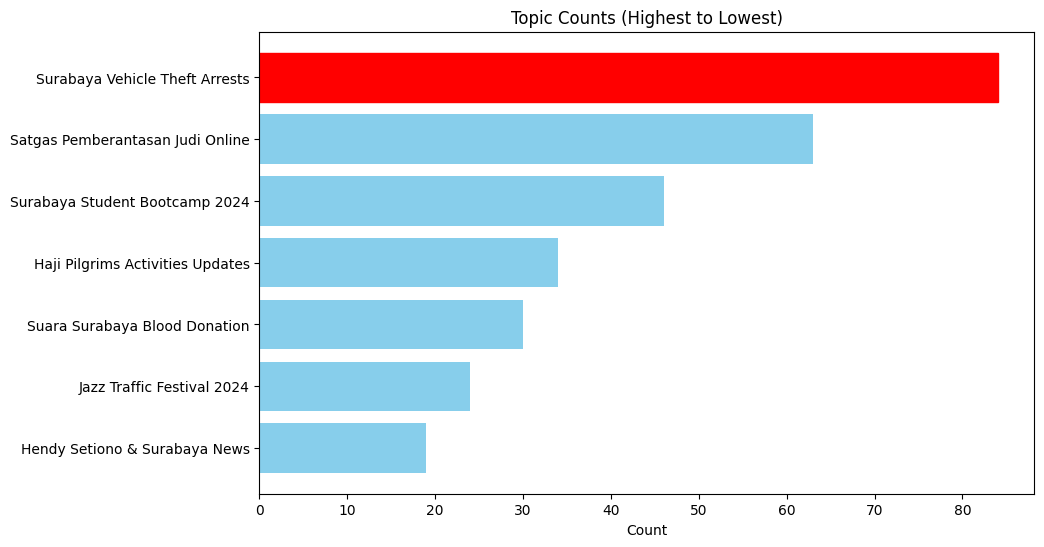

In [99]:
import matplotlib.pyplot as plt

# Data
topics = ['Surabaya Student Bootcamp 2024', 'Surabaya Vehicle Theft Arrests', 
          'Satgas Pemberantasan Judi Online', 'Haji Pilgrims Activities Updates', 
          'Suara Surabaya Blood Donation', 'Jazz Traffic Festival 2024', 
          'Hendy Setiono & Surabaya News']
counts = [46, 84, 63, 34, 30, 24, 19]

# Sorting data
sorted_data = sorted(zip(topics, counts), key=lambda x: x[1], reverse=True)
sorted_topics = [x[0] for x in sorted_data]
sorted_counts = [x[1] for x in sorted_data]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_topics, sorted_counts, color='skyblue')

# Highlighting the highest bar in red
bars[0].set_color('red')

plt.xlabel('Count')
plt.title('Topic Counts (Highest to Lowest)')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()


In [95]:
topic_model.visualize_barchart(top_n_topics=10)